In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine
import mysql.connector
import pickle

%matplotlib inline

In [2]:
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [3]:
# Connect to MySQL database
conn = mysql.connector.connect(host='127.0.0.1', user='root', passwd=password)
cursor = conn.cursor()

#Select the database
cursor.execute("USE vanguard")

In [6]:
cursor.execute("""WITH total_interactions AS (
                                                SELECT 
                                                    clients.client_id,
                                                    interactions.visit_id,
                                                    interactions.process_step,
                                                    COUNT(interactions.process_step) AS step_count
                                                FROM clients
                                                JOIN interactions 
                                                ON clients.client_id = interactions.client_id
                                                GROUP BY 
                                                    clients.client_id,
                                                    interactions.visit_id,
                                                    interactions.process_step)
                SELECT sum(step_count)
                FROM total_interactions;  

                    """)
results = cursor.fetchall()

total_interactions = pd.DataFrame(results)

In [7]:
total_interactions

,0
0,449831


In [10]:
cursor.execute("""WITH error_search AS(
                                        SELECT 
                                                clients.client_id,
                                                interactions.visit_id,
                                                interactions.process_step,
                                                COUNT(interactions.process_step) AS step_count
                                        FROM clients
                                        JOIN interactions 
                                        ON clients.client_id = interactions.client_id
                                        GROUP BY 
                                                clients.client_id,
                                                interactions.visit_id,
                                                interactions.process_step
                                        )
                SELECT client_id,
                        visit_id,
                        process_step,
                        step_count
                FROM error_search
                GROUP BY 
                        client_id,
                        visit_id,
                        process_step
;

                    """)
results = cursor.fetchall()

error_search = pd.DataFrame(results)

In [11]:
error_search

,0,1,2,3
0,8320017,960651974_70596002104_312201,4,1
1,8320017,960651974_70596002104_312201,3,1
2,8320017,960651974_70596002104_312201,2,1
3,8320017,960651974_70596002104_312201,1,1
4,8320017,960651974_70596002104_312201,0,1
...,...,...,...,...
334979,104557,130036090_50724060621_44337,4,2
334980,104557,130036090_50724060621_44337,3,1
334981,104557,130036090_50724060621_44337,2,1
334982,104557,130036090_50724060621_44337,1,1


In [12]:
error_search.rename(columns = {0:'client_id', 1:'visit_id', 2:'process_step', 3:'step_count'}, inplace=True)
error_search


,client_id,visit_id,process_step,step_count
0,8320017,960651974_70596002104_312201,4,1
1,8320017,960651974_70596002104_312201,3,1
2,8320017,960651974_70596002104_312201,2,1
3,8320017,960651974_70596002104_312201,1,1
4,8320017,960651974_70596002104_312201,0,1
...,...,...,...,...
334979,104557,130036090_50724060621_44337,4,2
334980,104557,130036090_50724060621_44337,3,1
334981,104557,130036090_50724060621_44337,2,1
334982,104557,130036090_50724060621_44337,1,1


In [18]:
# we define error as visiting the same step in a visit more than once, so we filter out any times the step is only done once
# to focus on errors
error_search_filter = error_search[error_search["step_count"] > 1]
error_search_filter

,client_id,visit_id,process_step,step_count
9,5887227,458489157_53226123692_778999,0,3
17,2991219,86072289_72359314970_118413,4,2
20,2991219,86072289_72359314970_118413,1,2
28,2211277,896059633_15441762098_367819,4,2
39,2211277,621508253_79430774492_103580,1,2
...,...,...,...,...
334942,8525197,349494329_64993853658_231911,0,3
334943,8525197,349494329_64993853658_231911,1,2
334956,4802727,400096230_52836008190_825812,1,2
334957,4802727,400096230_52836008190_825812,0,3


In [27]:
# how many times each step was attempted in total
frequency_table = error_search_filter['process_step'].value_counts()
frequency_table 

# how many times attempts were made on a step. Example, a step was attempted twice 47,020 times
frequency_table_attempt = error_search_filter['step_count'].value_counts()
frequency_table_attempt

step_count
2     47020
3     13895
4      5743
5      1968
6       952
7       471
8       409
9       147
10       77
11       44
16       39
12       33
13       21
14        8
24        8
15        8
32        6
19        5
17        3
18        2
23        2
20        2
33        1
21        1
40        1
48        1
Name: count, dtype: int64

In [29]:
# Calculating the proportion of attempts of each step. 43% of attempts were on step 1
proportion_table = error_search_filter['process_step'].value_counts(normalize=True)
proportion_table

# the proportion of attempts were made on a same step. Example, a step was attempted twice 47,020 times
proportion_table = error_search_filter['step_count'].value_counts(normalize=True)
proportion_table

step_count
2     0.663496
3     0.196072
4     0.081039
5     0.027770
6     0.013434
7     0.006646
8     0.005771
9     0.002074
10    0.001087
11    0.000621
16    0.000550
12    0.000466
13    0.000296
14    0.000113
24    0.000113
15    0.000113
32    0.000085
19    0.000071
17    0.000042
18    0.000028
23    0.000028
20    0.000028
33    0.000014
21    0.000014
40    0.000014
48    0.000014
Name: proportion, dtype: float64

<Axes: xlabel='process_step'>

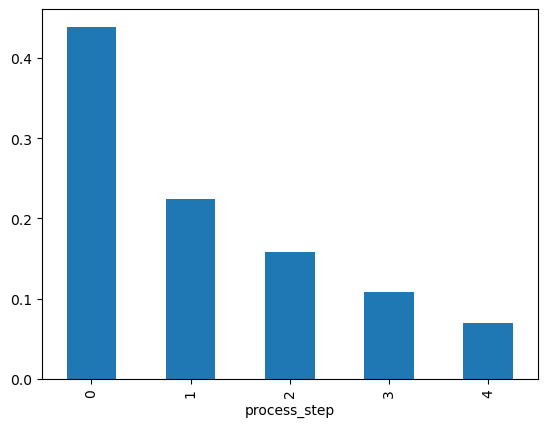

In [37]:
# Calculating the proportion of attempts of each step. 43% of attempts were on step 0
proportion_table = error_search_filter['process_step'].value_counts(normalize=True)
proportion_table

proportion_table.plot(kind="bar")

In [33]:
#number of attempts on each step, not accounting for single attempts

pivot_df = pd.pivot_table(
     error_search_filter, 
    values='step_count', 
    columns='process_step', 
    aggfunc='sum', 
    fill_value=0
)

pivot_df

process_step,0,1,2,3,4
step_count,86888,39175,28158,19090,12403


In [38]:
cursor.execute("""WITH error_search AS(
						SELECT 
							clients.client_id,
							interactions.visit_id,
							interactions.process_step,
							COUNT(interactions.process_step) AS step_count
						FROM 
							clients
						JOIN 
							interactions ON clients.client_id = interactions.client_id
						JOIN group_id ON group_id.client_id = interactions.client_id
						WHERE group_id.variation = 'Test'
                        GROUP BY 
							clients.client_id,
							interactions.visit_id,
							interactions.process_step
						
                        HAVING 
							COUNT(interactions.process_step) >1
						)
SELECT client_id,
		visit_id,
		process_step,
		step_count
FROM error_search
GROUP BY 
		client_id,
		visit_id,
		process_step
;

                    """)
results = cursor.fetchall()

test_group_errors = pd.DataFrame(results)

In [40]:
# table showing errors by test group

test_group_errors 

test_group_errors .rename(columns = {0:'client_id', 1:'visit_id', 2:'process_step', 3:'step_count'}, inplace=True)
test_group_errors 

,client_id,visit_id,process_step,step_count
0,9988021,781255054_21935453173_531117,3,3
1,9988021,781255054_21935453173_531117,2,3
2,9466803,812185460_4263902139_352107,0,3
3,9466803,812185460_4263902139_352107,1,2
4,5887227,458489157_53226123692_778999,0,3
...,...,...,...,...
29234,2264189,745778224_19702272577_843573,2,3
29235,2264189,745778224_19702272577_843573,1,2
29236,8404715,121663566_4529621135_381829,4,3
29237,8404715,804876797_74424040817_364285,0,2


<Axes: xlabel='process_step'>

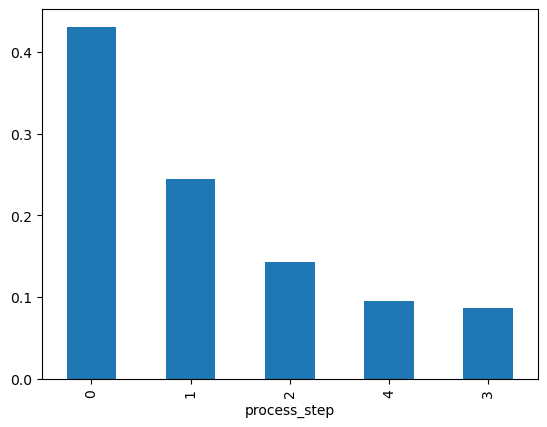

In [52]:
frequency_test = test_group_errors['process_step'].value_counts()
frequency_test

proportion_test = test_group_errors['process_step'].value_counts(normalize=True)
proportion_test

proportion_test.plot(kind="bar")

<Axes: xlabel='process_step'>

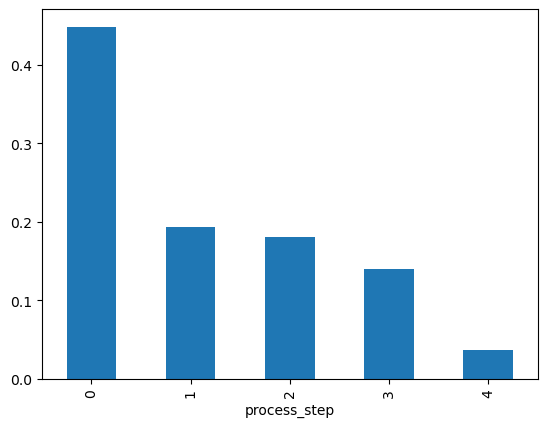

In [54]:
frequency_control = control_group_errors ['process_step'].value_counts()
frequency_control


proportion_control = control_group_errors['process_step'].value_counts(normalize=True)
proportion_control

proportion_control.plot(kind="bar")

In [41]:
cursor.execute("""WITH error_search AS(
						SELECT 
							clients.client_id,
							interactions.visit_id,
							interactions.process_step,
							COUNT(interactions.process_step) AS step_count
						FROM 
							clients
						JOIN 
							interactions ON clients.client_id = interactions.client_id
						JOIN group_id ON group_id.client_id = interactions.client_id
						WHERE group_id.variation = 'Control'
                        GROUP BY 
							clients.client_id,
							interactions.visit_id,
							interactions.process_step
						
                        HAVING 
							COUNT(interactions.process_step) >1
						)
SELECT client_id,
		visit_id,
		process_step,
		step_count
FROM error_search
GROUP BY 
		client_id,
		visit_id,
		process_step
;

                    """)
results = cursor.fetchall()

control_group_errors = pd.DataFrame(results)

In [43]:
control_group_errors

control_group_errors.rename(columns = {0:'client_id', 1:'visit_id', 2:'process_step', 3:'step_count'}, inplace=True)
control_group_errors

,client_id,visit_id,process_step,step_count
0,4033851,949661017_22392791362_127391,4,3
1,4033851,949661017_22392791362_127391,3,4
2,4033851,949661017_22392791362_127391,2,4
3,4033851,949661017_22392791362_127391,1,2
4,4033851,949661017_22392791362_127391,0,2
...,...,...,...,...
21406,4210290,854047956_97424100806_110138,0,4
21407,8249112,9694881_90240290095_634246,0,2
21408,7724739,142934306_68489763578_709953,4,2
21409,1677096,160129839_45725822849_906476,1,2


In [ ]:
# control had 21,411 step attempts with errors
# test had 29239 step attempts with errors

## Original Work by Danielle

In [2]:
import pickle

#Replace 'path_to_pickle_file.pkl' with the actual path to your pickle file
file_path = 'error_step.pkl'

#Open the file in binary read mode and load its contents
with open(file_path, 'rb') as file:
    data = pickle.load(file)

#Now 'data' contains the content of the pickle file
print(data)


                                  0        1  2  3
0       68804396_74737424429_397490  1000062  0  1
1       68804396_74737424429_397490  1000062  1  1
2       68804396_74737424429_397490  1000062  2  1
3       68804396_74737424429_397490  1000062  3  1
4       68804396_74737424429_397490  1000062  4  1
...                             ...      ... .. ..
557609   931268933_219402947_599432  9999875  0  1
557610   931268933_219402947_599432  9999875  1  2
557611   931268933_219402947_599432  9999875  2  1
557612   931268933_219402947_599432  9999875  3  1
557613   931268933_219402947_599432  9999875  4  1

[557614 rows x 4 columns]


In [3]:
data

,0,1,2,3
0,68804396_74737424429_397490,1000062,0,1
1,68804396_74737424429_397490,1000062,1,1
2,68804396_74737424429_397490,1000062,2,1
3,68804396_74737424429_397490,1000062,3,1
4,68804396_74737424429_397490,1000062,4,1
...,...,...,...,...
557609,931268933_219402947_599432,9999875,0,1
557610,931268933_219402947_599432,9999875,1,2
557611,931268933_219402947_599432,9999875,2,1
557612,931268933_219402947_599432,9999875,3,1


In [4]:
data.rename(columns = {0:'visitor_id', 1:'client_id', 2:'process_steps', 3:'count_of_steps'}, inplace=True)
data


,visitor_id,client_id,process_steps,count_of_steps
0,68804396_74737424429_397490,1000062,0,1
1,68804396_74737424429_397490,1000062,1,1
2,68804396_74737424429_397490,1000062,2,1
3,68804396_74737424429_397490,1000062,3,1
4,68804396_74737424429_397490,1000062,4,1
...,...,...,...,...
557609,931268933_219402947_599432,9999875,0,1
557610,931268933_219402947_599432,9999875,1,2
557611,931268933_219402947_599432,9999875,2,1
557612,931268933_219402947_599432,9999875,3,1


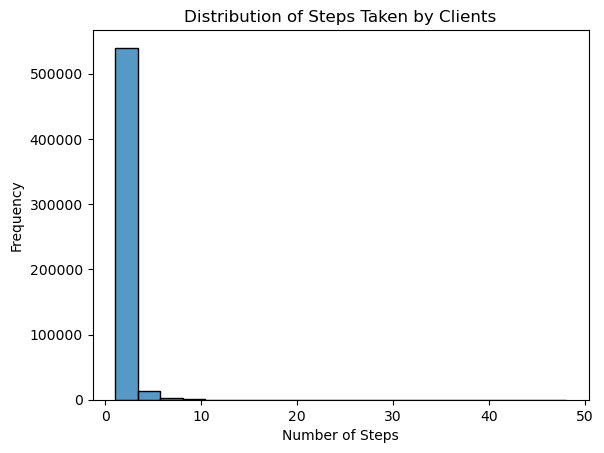

In [8]:
# Plot distribution of steps taken
sns.histplot(data['count_of_steps'], bins=20)
plt.xlabel('Number of Steps')
plt.ylabel('Frequency')
plt.title('Distribution of Steps Taken by Clients')
plt.show()

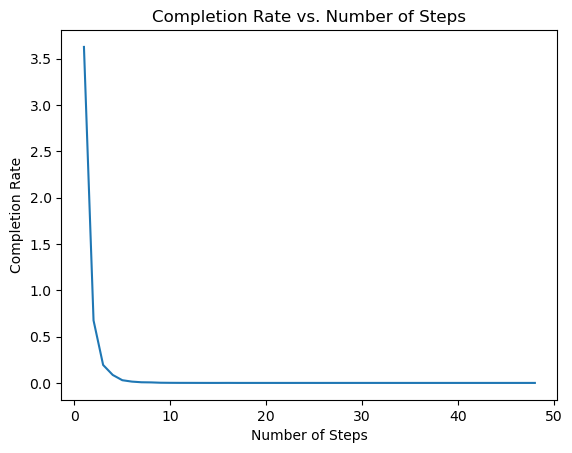

In [9]:
# Determine completion rates
completion_rates = data.groupby('count_of_steps')['client_id'].count() / data['client_id'].nunique()
completion_rates = completion_rates.reset_index()
completion_rates.columns = ['count_of_steps', 'completion_rate']

# Plot completion rates
sns.lineplot(x='count_of_steps', y='completion_rate', data=completion_rates)
plt.xlabel('Number of Steps')
plt.ylabel('Completion Rate')
plt.title('Completion Rate vs. Number of Steps')
plt.show()

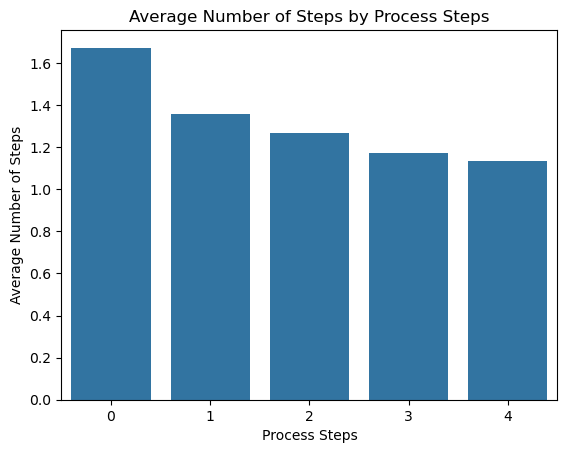

In [10]:
# Average steps by process steps
average_steps = data.groupby('process_steps')['count_of_steps'].mean().reset_index()

# Plot average steps
sns.barplot(x='process_steps', y='count_of_steps', data=average_steps)
plt.xlabel('Process Steps')
plt.ylabel('Average Number of Steps')
plt.title('Average Number of Steps by Process Steps')
plt.show()

# Distribution of Steps Taken by Clients:

#The histogram shows that most clients complete their tasks within a smaller number of steps, indicating that the process might be efficient for a majority of users.

#Completion Rate vs. Number of Steps:

#The line plot indicates that the completion rate decreases as the number of steps increases. This suggests that users are less likely to complete processes that require more steps.
#Average Number of Steps by Process Steps:

#The bar plot shows the average number of steps for each process step. This can help identify which steps in the process are more time-consuming and might need improvement.

In [15]:
# Load the data (replace 'your_data.csv' with the actual file path)
data = pd.read_csv('error_step.csv')

# Display the first few rows of the dataset
print(data.head())

# Display information about the dataset
print(data.info())

# Display basic statistics for numerical columns
print(data.describe())

                    visitor_id  client_id  process_steps  count_of_steps
0  68804396_74737424429_397490    1000062              0               1
1  68804396_74737424429_397490    1000062              1               1
2  68804396_74737424429_397490    1000062              2               1
3  68804396_74737424429_397490    1000062              3               1
4  68804396_74737424429_397490    1000062              4               1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557614 entries, 0 to 557613
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   visitor_id      557614 non-null  object
 1   client_id       557614 non-null  int64 
 2   process_steps   557614 non-null  int64 
 3   count_of_steps  557614 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 17.0+ MB
None
          client_id  process_steps  count_of_steps
count  5.576140e+05  557614.000000   557614.000000
mean   5.012493e+06     

In [16]:
# Check for missing values
print(data.isnull().sum())

# Handle missing values (for simplicity, dropping them)
data = data.dropna()

# Ensure data types are correct
data['visitor_id'] = data['visitor_id'].astype(str)
data['client_id'] = data['client_id'].astype(str)
data['process_steps'] = data['process_steps'].astype(int)
data['count_of_steps'] = data['count_of_steps'].astype(int)


visitor_id        0
client_id         0
process_steps     0
count_of_steps    0
dtype: int64


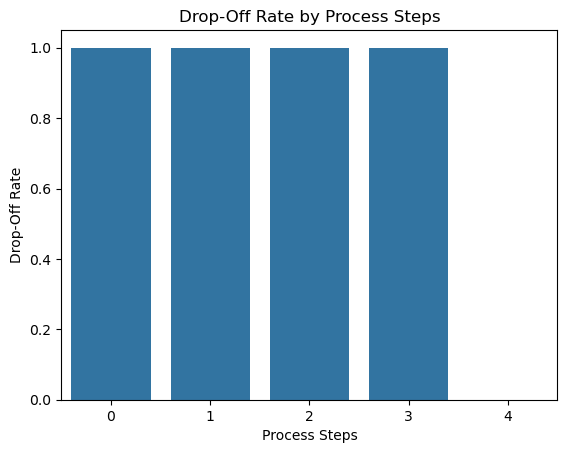

In [17]:
# Create a new column to indicate if a user dropped off (1 if dropped off, 0 otherwise)
# Assuming the maximum step in the process is `max_step`
max_step = data['process_steps'].max()
data['drop_off'] = data.apply(lambda row: 1 if row['process_steps'] < max_step else 0, axis=1)

# Calculate drop-off rate by process steps
drop_off_rate_by_process = data.groupby('process_steps')['drop_off'].mean().reset_index()
drop_off_rate_by_process.columns = ['process_steps', 'drop_off_rate']

# Plot drop-off rate by process steps
sns.barplot(x='process_steps', y='drop_off_rate', data=drop_off_rate_by_process)
plt.xlabel('Process Steps')
plt.ylabel('Drop-Off Rate')
plt.title('Drop-Off Rate by Process Steps')
plt.show()


Conclusion: 

Drop-Off Rate by Process Steps:

The bar plot indicates which steps in the process have the highest drop-off rates, suggesting areas where users are more likely to abandon the process.

# Error Rates:
Definition: The frequency of instances where users go back to a previous step, indicating potential confusion or errors.
Calculation: Number of instances where users go back to a previous step / Total number of users.


In [19]:
# Display the first few rows of the dataset
print(data.head())

# Display information about the dataset
print(data.info())

# Display basic statistics for numerical columns
print(data.describe())

# Ensure data is sorted by visitor_id and process_steps
data = data.sort_values(by=['visitor_id', 'process_steps'])

# Create a new column to indicate the previous step for each user
data['previous_step'] = data.groupby('visitor_id')['process_steps'].shift(1)

# Identify where users go back to a previous step
data['went_back'] = np.where(data['process_steps'] < data['previous_step'], 1, 0)

# Calculate the number of instances where users go back to a previous step
instances_of_going_back = data['went_back'].sum()

# Calculate the total number of unique users
total_users = data['visitor_id'].nunique()

# Calculate the desired metric
metric = instances_of_going_back / total_users

print(f"Number of instances where users go back to a previous step: {instances_of_going_back}")
print(f"Total number of users: {total_users}")
print(f"Metric (instances of going back / total users): {metric:.2%}")

                    visitor_id client_id  process_steps  count_of_steps  \
0  68804396_74737424429_397490   1000062              0               1   
1  68804396_74737424429_397490   1000062              1               1   
2  68804396_74737424429_397490   1000062              2               1   
3  68804396_74737424429_397490   1000062              3               1   
4  68804396_74737424429_397490   1000062              4               1   

   drop_off  
0         1  
1         1  
2         1  
3         1  
4         0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557614 entries, 0 to 557613
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   visitor_id      557614 non-null  object
 1   client_id       557614 non-null  object
 2   process_steps   557614 non-null  int64 
 3   count_of_steps  557614 non-null  int64 
 4   drop_off        557614 non-null  int64 
dtypes: int64(3), object(2)
memory usage

In [7]:

#0 - visitor id 

#1 client id 

#2 - process_step

#3 - count_of_step



In [5]:
#data.to_csv('error_step.csv', index=False)